# Flu Modeling Notebook 🦠

### Step One: Import Libraries

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math as m
import tqdm as tqdm

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
path = "../Data/more_combined_data.csv"
scale = StandardScaler()
df_show = pd.read_csv(path)
df_show.head()

,DATE,YEAR,WEEK,% WEIGHTED ILI,REGIONAL ILI BASELINE,ABOVE BASELINE,IS FLUWEEK,AGE 0-4,AGE 5-24,AGE 25-64,...,COOLING DAYS MONTHLY,HEATING DAYS MONTHLY,PRECIPITATION MONTHLY,AVG TEMP MONTHLY,POPULATION,VAXEFFECTIVENESS,VACCINERATENATIONAL,AWND,PRCP,TAVG
0,2003-10-05,2003,40,0.572031,0.782203,0,0,14,40,27,...,0.0,266.2,150.1,9.7,14182454,52,12.7,2.805714,1.808571,11.100000
1,2003-10-12,2003,41,0.449279,0.782203,0,0,6,35,35,...,0.0,266.2,150.1,9.7,14182454,52,12.7,2.480000,2.726190,12.740000
2,2003-10-19,2003,42,0.613789,0.782203,0,0,19,60,32,...,0.0,266.2,150.1,9.7,14182454,52,12.7,3.634286,5.311905,10.291429
3,2003-10-26,2003,43,0.661170,0.782203,0,0,32,56,33,...,0.0,266.2,150.1,9.7,14182454,52,12.7,3.974286,2.473333,7.068571
4,2003-11-02,2003,44,0.760914,0.782203,0,0,31,74,38,...,0.0,375.4,77.7,5.6,14182454,52,12.7,3.291429,9.711905,12.899286


In [74]:
df_show.dtypes

DATE                            object
YEAR                             int64
WEEK                             int64
% WEIGHTED ILI                 float64
REGIONAL ILI BASELINE          float64
ABOVE BASELINE                   int64
IS FLUWEEK                       int64
AGE 0-4                          int64
AGE 5-24                         int64
AGE 25-64                        int64
AGE 65                           int64
ILITOTAL                         int64
NUM. OF PROVIDERS                int64
TOTAL PATIENTS                   int64
TOTAL SPECIMENS                  int64
A (Subtyping not Performed)      int64
A (2009 H1N1)                    int64
A (H1)                           int64
A (H3)                           int64
B                                int64
Bvic                             int64
Byam                             int64
AVG WIND SPEED MONTHLY         float64
COOLING DAYS MONTHLY           float64
HEATING DAYS MONTHLY           float64
PRECIPITATION MONTHLY    

In [75]:
class Flu_Dataset(Dataset):
    def __init__(self, filename):
        # Read-In DataFrame
        df = pd.read_csv(filename)
        
        # Convert 'DATE' to datetime and extract useful features
        df['DATE'] = pd.to_datetime(df['DATE'])
        df['YEAR'] = df['DATE'].dt.year
        df['MONTH'] = df['DATE'].dt.month
        df['WEEK'] = df['DATE'].dt.isocalendar().week
        df['ILI_t+1'] = df['% WEIGHTED ILI'].shift(-1)
        df.drop("DATE", axis=1, inplace=True)

        # Re-Order Target to Last Col
        global cols
        cols = df.columns.tolist()
        cols.remove('% WEIGHTED ILI')
        cols.append('% WEIGHTED ILI')
        df = df[cols]

        # Initialize separate scalers for features and target
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()
        
        # Scale Features and Target separately
        features = df.iloc[:, :-1]
        target = df.iloc[:, -1:]

        # Fit and transform features and target separately
        scaled_features = self.feature_scaler.fit_transform(features)
        scaled_target = self.target_scaler.fit_transform(target)
        
        # Convert to Torch Tensors
        self.x = torch.tensor(scaled_features, dtype=torch.float32)
        self.y = torch.tensor(scaled_target, dtype=torch.float32)

    # Define Mandatory length method
    def __len__(self):
        return len(self.y)
    
    # Define Mandatory Get Item Method
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # Split into desired train-test split
    def split_data(self, n_test):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        return random_split(self, [train_size, test_size])

In [76]:
# Instantiate Class with Dataset
flu_df = Flu_Dataset(path)

# Split into 80/20 Train-Test
train, test = flu_df.split_data(n_test=0.20)

# Use DataLoader directly on the split dataset
train = DataLoader(train, batch_size=32, shuffle=True)
test = DataLoader(test, batch_size=32, shuffle=True)

print("Train Length: ", len(train))
print("Test Length: ", len(test))

Train Length:  21
Test Length:  6


Epoch [1/1000], Average Loss: 0.6813
Epoch [2/1000], Average Loss: 0.2030
Epoch [3/1000], Average Loss: 0.1452
Epoch [4/1000], Average Loss: 0.0964
Epoch [5/1000], Average Loss: 0.0703
Epoch [6/1000], Average Loss: 0.0503
Epoch [7/1000], Average Loss: 0.0442
Epoch [8/1000], Average Loss: 0.0386
Epoch [9/1000], Average Loss: 0.0376
Epoch [10/1000], Average Loss: 0.0360
Epoch [11/1000], Average Loss: 0.0327
Epoch [12/1000], Average Loss: 0.0330
Epoch [13/1000], Average Loss: 0.0340
Epoch [14/1000], Average Loss: 0.0336
Epoch [15/1000], Average Loss: 0.0329
Epoch [16/1000], Average Loss: 0.0292
Epoch [17/1000], Average Loss: 0.0277
Epoch [18/1000], Average Loss: 0.0307
Epoch [19/1000], Average Loss: 0.0274
Epoch [20/1000], Average Loss: 0.0272
Epoch [21/1000], Average Loss: 0.0270
Epoch [22/1000], Average Loss: 0.0233
Epoch [23/1000], Average Loss: 0.0250
Epoch [24/1000], Average Loss: 0.0261
Epoch [25/1000], Average Loss: 0.0238
Epoch [26/1000], Average Loss: 0.0294
Epoch [27/1000], Aver

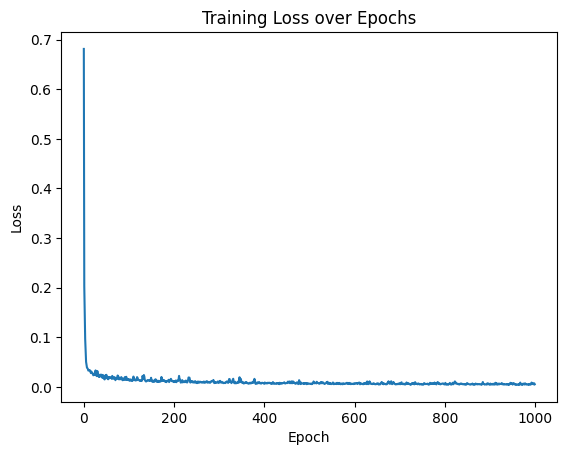

In [77]:
# Set parameters
input_size = len(cols) - 1
learning_rate = 0.0001
num_epochs = 1000

class Build_Model(nn.Module):
    def __init__(self, input_size):
        super(Build_Model, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=512, batch_first=True, num_layers=2, dropout=0.2)
        
        # Fully connected layers
        self.dense_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.SELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Adds a time dimension of size 1
        lstm_out, _ = self.lstm(x)
        
        # Take only the last output for each sequence
        lstm_out = lstm_out[:, -1, :]
        
        # Pass through dense layers
        output = self.dense_layers(lstm_out)

        return output

# Initialize model
model = Build_Model(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.MSELoss()


# Training Loop
loss_values = []
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_features, batch_labels in train:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Average loss per epoch
    avg_loss = epoch_loss / len(train)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Plot Loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [78]:
# Switch model to evaluation mode
model.eval()

# Collect predictions and targets
predictions = []
targets = []

# Inference on validation/test data
with torch.no_grad():
    for batch_features, batch_labels in test:
        # Forward pass
        outputs = model(batch_features)
        
        # Store predictions and true values
        predictions.extend(outputs.cpu().numpy())
        targets.extend(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Rescale predictions and targets back to original units
predictions_rescaled = flu_df.target_scaler.inverse_transform(predictions)
targets_rescaled = flu_df.target_scaler.inverse_transform(targets)

# Calculate MSE loss on the rescaled data
mse_loss_rescaled = np.mean((predictions_rescaled - targets_rescaled) ** 2)
print("Rescaled MSE Loss:", mse_loss_rescaled)
print("RMSE Re-Scaled: ", m.sqrt(mse_loss_rescaled))

Rescaled MSE Loss: 0.034387004
RMSE Re-Scaled:  0.1854373307357494


In [54]:
class Secondary_Model(nn.Module):
    def __init__(self, input_size):
        super(Secondary_Model, self).__init__()
        
        # GRU layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=256, batch_first=True, num_layers=3, dropout=0.3)
        self.layer_norm = nn.LayerNorm(256)  # LayerNorm for stable training
        
        # Fully connected layers
        self.dense_layers = nn.Sequential(
            nn.Linear(256, 128),  # 256 from GRU hidden size
            nn.SELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, 1)  # Single output for regression
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Adds a time dimension of size 1
        
        # GRU forward pass
        gru_out, _ = self.gru(x)  # Output shape: (batch, seq_len, hidden_size)
        gru_out = gru_out[:, -1, :]  # Take the last hidden state (shape: batch, hidden_size)
        gru_out = self.layer_norm(gru_out)  # Normalize
        
        # Pass through dense layers
        output = self.dense_layers(gru_out)
        return output

In [56]:
# Initialize model
secondary_model = Secondary_Model(input_size=input_size)
optimizer = torch.optim.Adam(secondary_model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# Training loop similar to the primary model
loss_values = []
secondary_model.train()

num_epochs = 10000

for epoch in range(num_epochs):
    epoch_loss = 0
    # Add tqdm to the training loop
    with tqdm(total=len(train), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
        for batch_features, batch_labels in train:
            # Forward pass
            outputs = secondary_model(batch_features)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)

Epoch [10000/10000]: 100%|██████████| 21/21 [00:00<00:00, 230.71batch/s, Batch Loss=0.000127]


In [88]:
# Evaluate Secondary Model
secondary_model.eval()

# Collect predictions and targets for secondary model
predictions_secondary = []
targets_secondary = []

# Inference on validation/test data for secondary model
with torch.no_grad():
    for batch_features, batch_labels in test:
        # Forward pass
        outputs = secondary_model(batch_features)
        
        # Store predictions and true values
        predictions_secondary.extend(outputs.cpu().numpy())
        targets_secondary.extend(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
predictions_secondary = np.array(predictions_secondary).reshape(-1, 1)  # Ensure 2D shape for inverse transform
targets_secondary = np.array(targets_secondary).reshape(-1, 1)

# Rescale predictions and targets back to original units
predictions_secondary_rescaled = flu_df.target_scaler.inverse_transform(predictions_secondary)
targets_secondary_rescaled = flu_df.target_scaler.inverse_transform(targets_secondary)

# Calculate MSE and RMSE loss on the rescaled data
mse_secondary_rescaled = np.mean((predictions_secondary_rescaled - targets_secondary_rescaled) ** 2)
rmse_secondary_rescaled = m.sqrt(mse_secondary_rescaled)

# Print actual vs predicted for secondary model
print("Secondary Model Actual vs Predicted (Rescaled):")
for i in range(10):  # Print first 10 for brevity
    print(f"Actual: {targets_secondary_rescaled[i][0]:.4f}, Predicted: {predictions_secondary_rescaled[i][0]:.4f}")

print("\nSecondary Model Rescaled MSE Loss:", mse_secondary_rescaled)
print("Secondary Model Rescaled RMSE Loss:", rmse_secondary_rescaled)

Secondary Model Actual vs Predicted (Rescaled):
Actual: 0.3812, Predicted: 0.4648
Actual: 1.7956, Predicted: 1.7843
Actual: 0.6818, Predicted: 0.7081
Actual: 0.3436, Predicted: 0.4321
Actual: 0.6219, Predicted: 0.6564
Actual: 0.7601, Predicted: 0.7845
Actual: 0.8838, Predicted: 0.7614
Actual: 1.3091, Predicted: 1.2615
Actual: 0.3779, Predicted: 0.4611
Actual: 0.3005, Predicted: 0.4005

Secondary Model Rescaled MSE Loss: 0.008649534
Secondary Model Rescaled RMSE Loss: 0.09300286885099975
